# XGBoost Algorithm with Histogram-Based Boosting

In addition to Linear Regression, Lasso model and the XGBoost which are instrumental to solve regression problems, we tried Random Forest and various other methodologies. However we've come to a point that XGB works the most efficient way to predict revenue figures with good accuracy by avoiding overfitting.

In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import HistGradientBoostingRegressor  # Alternative during GridSearch


## EDA 2.0: Apply Learnings into the Data

### Drop Columns

In [40]:
# Bring the Weekly Data

weekly_mmm = pd.read_csv("weekly_data.csv")
weekly_mmm.columns

Index(['Week', 'Month_Year', 'Promo_Exists', 'Consumer_Index',
       'Inflation_Rate', 'Gross_Rating_Point', 'Month', 'Year', 'Search_Spend',
       'Display_Spend', 'Video_Spend', 'Social_Spend', 'Digital_Audio_Spend',
       'TV_Spend', 'Radio_Spend', 'OOH_Spend', 'revenue', 'salescount',
       'Search_Views', 'Social_Views', 'Video_Views', 'Display_Views',
       'Audio_Views', 'Search_Clicks', 'Social_Clicks', 'Video_Clicks',
       'Display_Clicks', 'Audio_Clicks', 'category_Books', 'category_Clothing',
       'category_Electronics', 'category_Home', 'Sales_Channel_Digital Audio',
       'Sales_Channel_Display', 'Sales_Channel_Offline',
       'Sales_Channel_Search', 'Sales_Channel_Social', 'Sales_Channel_Video'],
      dtype='object')

In [41]:
# Identify click and view columns
click_cols = [col for col in weekly_mmm.columns if "_Clicks" in col]
view_cols = [col for col in weekly_mmm.columns if "_Views" in col]

# Compute total Click-Through Rate (CTR)
weekly_mmm["CTR"] = weekly_mmm[click_cols].sum(axis=1) / (weekly_mmm[view_cols].sum(axis=1) + 1e-6)  # Avoid division by zero

# Drop all columns from 'salescount' onwards except 'CTR'
drop_cols = [col for col in weekly_mmm.columns if weekly_mmm.columns.get_loc(col) >= weekly_mmm.columns.get_loc("salescount") and col != "CTR"]
weekly_mmm.drop(columns=drop_cols, inplace=True)

In [42]:
weekly_mmm.head()

,Week,Month_Year,Promo_Exists,Consumer_Index,Inflation_Rate,Gross_Rating_Point,Month,Year,Search_Spend,Display_Spend,Video_Spend,Social_Spend,Digital_Audio_Spend,TV_Spend,Radio_Spend,OOH_Spend,revenue,CTR
0,2022-12-26,2023-01-01,0,110.7,8.7,117.6,1,2023,29977.809599,4207.871135,3679.209237,4544.901565,2873.943003,8441.358831,2796.122756,3581.875562,180867.31,0.677163
1,2023-01-02,2023-01-01,0,110.7,8.7,117.6,7,14161,235357.151229,26247.843753,25756.202131,29980.176840,22101.022695,48775.389571,17050.861648,25416.576777,860972.40,0.607385
2,2023-01-09,2023-01-01,0,110.7,8.7,117.6,7,14161,234186.938263,26545.377010,26030.141143,32152.454071,22492.490939,53364.271304,17632.575856,26224.812934,855779.31,0.598568
3,2023-01-16,2023-01-01,0,110.7,8.7,117.6,7,14161,236415.991241,25535.800231,26926.958491,31331.985578,22229.716761,51564.367895,16732.820685,26709.199641,786444.19,0.604000
4,2023-01-23,2023-01-01,0,110.7,8.7,117.6,7,14161,236796.392545,26114.634553,26429.605963,29936.332556,22293.558418,49737.515348,17424.835103,25898.922928,809834.70,0.605625


In [43]:
from datetime import datetime, date, time, timedelta

weekly_mmm["Week_Date"] = pd.to_datetime(weekly_mmm["Week"])

# Added the Date Columnd

weekly_mmm

,Week,Month_Year,Promo_Exists,Consumer_Index,Inflation_Rate,Gross_Rating_Point,Month,Year,Search_Spend,Display_Spend,Video_Spend,Social_Spend,Digital_Audio_Spend,TV_Spend,Radio_Spend,OOH_Spend,revenue,CTR,Week_Date
0,2022-12-26,2023-01-01,0,110.7,8.7,117.6,1,2023,29977.809599,4207.871135,3679.209237,4544.901565,2873.943003,8441.358831,2796.122756,3581.875562,180867.31,0.677163,2022-12-26
1,2023-01-02,2023-01-01,0,110.7,8.7,117.6,7,14161,235357.151229,26247.843753,25756.202131,29980.176840,22101.022695,48775.389571,17050.861648,25416.576777,860972.40,0.607385,2023-01-02
2,2023-01-09,2023-01-01,0,110.7,8.7,117.6,7,14161,234186.938263,26545.377010,26030.141143,32152.454071,22492.490939,53364.271304,17632.575856,26224.812934,855779.31,0.598568,2023-01-09
3,2023-01-16,2023-01-01,0,110.7,8.7,117.6,7,14161,236415.991241,25535.800231,26926.958491,31331.985578,22229.716761,51564.367895,16732.820685,26709.199641,786444.19,0.604000,2023-01-16
4,2023-01-23,2023-01-01,0,110.7,8.7,117.6,7,14161,236796.392545,26114.634553,26429.605963,29936.332556,22293.558418,49737.515348,17424.835103,25898.922928,809834.70,0.605625,2023-01-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,2024-12-02,2024-12-01,1,115.1,2.6,202.3,84,14168,351429.220421,55216.631347,70811.034132,56946.495987,41597.239853,123973.597040,31384.469380,46357.437368,2723999.86,0.676450,2024-12-02
121,2024-12-09,2024-12-01,1,115.1,2.6,202.3,84,14168,368588.936465,53306.935185,73950.735213,53758.587590,41753.408555,126139.046597,29729.337278,49442.153921,2846124.57,0.678054,2024-12-09
122,2024-12-16,2024-12-01,1,115.1,2.6,202.3,84,14168,368274.285674,54401.649683,67901.930524,55689.731923,39106.401039,130193.434771,30277.830940,49352.246647,2842753.15,0.677150,2024-12-16
123,2024-12-23,2024-12-01,1,115.1,2.6,202.3,84,14168,351452.118185,54452.625564,71648.795681,52429.517401,38255.064448,117326.065766,32363.665519,48069.899430,2895681.71,0.677697,2024-12-23


### Adstock Function: Carryover Effect

In [44]:
def adstock_transform(data, spend_column, carryover_factor):
    """
    Applies Adstock transformation to an advertising spend column.

    Args:
        data (pd.DataFrame): DataFrame containing weekly data.
        spend_column (str): The name of the ad spend column to transform.
        carryover_factor (float): The carryover effect (0 to 1).

    Returns:
        pd.Series: Transformed ad spend with Adstock effect.
    """
    adstocked_values = []
    prev_adstock = 0  # Initial carryover effect is 0

    for spend in data[spend_column]:
        current_adstock = spend + (prev_adstock * carryover_factor)
        adstocked_values.append(current_adstock)
        prev_adstock = current_adstock  # Update carryover effect

    return pd.Series(adstocked_values, index=data.index)

# Define different carryover factors
offline_carryover_factor = 0.3
online_carryover_factor = 0.5

# Define offline and online spend categories
offline_channels = ["TV_Spend", "Radio_Spend", "OOH_Spend"]

# Find all columns that end with "_Spend"
spend_columns = [col for col in weekly_mmm.columns if col.endswith("_Spend")]

# Apply adstock transformation based on category
for col in spend_columns:
    carryover_factor = offline_carryover_factor if col in offline_channels else online_carryover_factor
    weekly_mmm[col + "_Adstock"] = adstock_transform(weekly_mmm, col, carryover_factor)

In [45]:
weekly_mmm.dtypes

Week                                   object
Month_Year                             object
Promo_Exists                            int64
Consumer_Index                        float64
Inflation_Rate                        float64
Gross_Rating_Point                    float64
Month                                   int64
Year                                    int64
Search_Spend                          float64
Display_Spend                         float64
Video_Spend                           float64
Social_Spend                          float64
Digital_Audio_Spend                   float64
TV_Spend                              float64
Radio_Spend                           float64
OOH_Spend                             float64
revenue                               float64
CTR                                   float64
Week_Date                      datetime64[ns]
Search_Spend_Adstock                  float64
Display_Spend_Adstock                 float64
Video_Spend_Adstock               

# Improved XGBoost Model with Hist-Based Estimator

In [46]:
# Define target variable
Y = "revenue"

# Define spend factors (adstocked spend per channel)
spend_factors = [
    "Search_Spend_Adstock",
    "Display_Spend_Adstock",
    "Video_Spend_Adstock",
    "Social_Spend_Adstock",
    "Digital_Audio_Spend_Adstock",
    "TV_Spend_Adstock",
    "Radio_Spend_Adstock",
    "OOH_Spend_Adstock"
]

# Define macroeconomic factors
macro_factors = [
    "Promo_Exists",
    "Consumer_Index",
    "Inflation_Rate",
    "Gross_Rating_Point"
]

# Feature Engineering: Normalize CTR using MinMaxScaler
scaler = MinMaxScaler()
weekly_mmm["CTR_Scaled"] = scaler.fit_transform(weekly_mmm[["CTR"]])

# Combine all features, including engineered CTR
X_columns = spend_factors + macro_factors + ["CTR_Scaled"]
X = weekly_mmm[X_columns]
y = weekly_mmm[Y]

In [47]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---- GridSearchCV using HistGradientBoostingRegressor (avoiding XGBRegressor error) ----
param_grid = {
    'learning_rate': [0.01, 0.05, 0.07, 0.08, 0.09, 0.1, 0.123, 0.125, 0.127, 0.2],
    'max_depth': [3, 5, 7, 10, 20],
    'max_iter': [50, 100, 200, 500],
}

hist_gbr = HistGradientBoostingRegressor(random_state=42)

grid_search = GridSearchCV(hist_gbr, param_grid, cv=5, scoring='r2', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters from GridSearchCV
best_params = grid_search.best_params_
print("Best Parameters from GridSearchCV:", best_params)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best Parameters from GridSearchCV: {'learning_rate': 0.08, 'max_depth': 3, 'max_iter': 500}


In [52]:
# ---- Train Final XGBoost Model using Best Parameters ----
best_xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    n_estimators=best_params['max_iter'],  # Convert max_iter from HistGradientBoostingRegressor to n_estimators for XGBoost
    random_state=42
)

best_xgb_model.fit(X_train, y_train)

# Predictions with the optimized model
y_pred = best_xgb_model.predict(X_test)

# Model Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)


In [53]:
print(f"\nOptimized Model Performance:\nRMSE: {rmse:.2f}\nR-squared: {r2:.4f}")

# Feature importance analysis
feature_importance = pd.DataFrame({'Feature': X_columns, 'Importance': best_xgb_model.feature_importances_})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

print("\nFeature Importance:\n", feature_importance)

# Save the best model
best_xgb_model.save_model("optimized_mmm_xgboost_model.json")


Optimized Model Performance:
RMSE: 428358.61
R-squared: 0.8348

Feature Importance:
                         Feature  Importance
2           Video_Spend_Adstock    0.297254
8                  Promo_Exists    0.134517
5              TV_Spend_Adstock    0.118843
11           Gross_Rating_Point    0.111435
10               Inflation_Rate    0.083482
6           Radio_Spend_Adstock    0.083368
12                   CTR_Scaled    0.081320
7             OOH_Spend_Adstock    0.020980
9                Consumer_Index    0.020318
1         Display_Spend_Adstock    0.016360
0          Search_Spend_Adstock    0.012056
4   Digital_Audio_Spend_Adstock    0.011295
3          Social_Spend_Adstock    0.008772


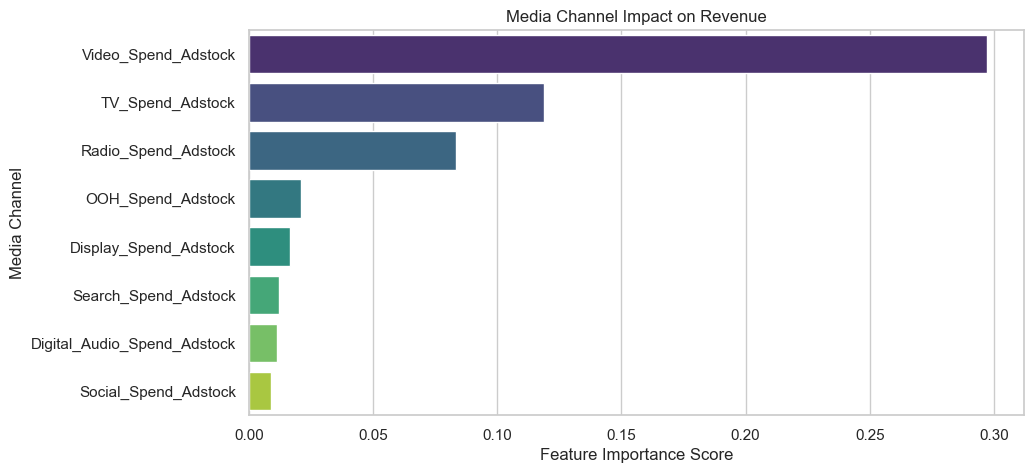

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# Extract feature importance from trained model
feature_importance_values = best_xgb_model.feature_importances_

# Get feature names from X (ensuring order matches importance values)
feature_names = X.columns.tolist()

# Create feature importance DataFrame
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance_values})

# Filter to include only media channels
media_channels = [
    "Search_Spend_Adstock", "Display_Spend_Adstock", "Video_Spend_Adstock",
    "Social_Spend_Adstock", "Digital_Audio_Spend_Adstock", "TV_Spend_Adstock",
    "Radio_Spend_Adstock", "OOH_Spend_Adstock"
]

feature_importance_df = feature_importance_df[feature_importance_df['Feature'].isin(media_channels)]

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df, palette="viridis")
plt.xlabel("Feature Importance Score")
plt.ylabel("Media Channel")
plt.title("Media Channel Impact on Revenue")
plt.show()

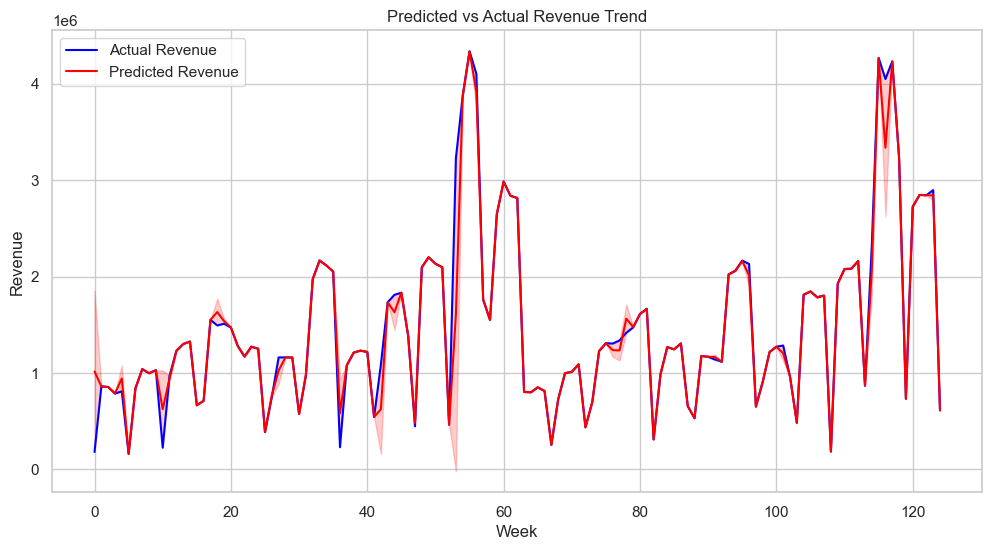

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generate predictions
weekly_mmm["Predicted_Revenue"] = best_xgb_model.predict(X)

# Compute residual error
weekly_mmm["Error"] = np.abs(weekly_mmm["revenue"] - weekly_mmm["Predicted_Revenue"])

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(x=weekly_mmm.index, y=weekly_mmm["revenue"], label="Actual Revenue", color="blue")
sns.lineplot(x=weekly_mmm.index, y=weekly_mmm["Predicted_Revenue"], label="Predicted Revenue", color="red")

# Error band
plt.fill_between(weekly_mmm.index, 
                 weekly_mmm["Predicted_Revenue"] - weekly_mmm["Error"], 
                 weekly_mmm["Predicted_Revenue"] + weekly_mmm["Error"], 
                 color='red', alpha=0.2)

plt.xlabel("Week")
plt.ylabel("Revenue")
plt.title("Predicted vs Actual Revenue Trend")
plt.legend()
plt.show()

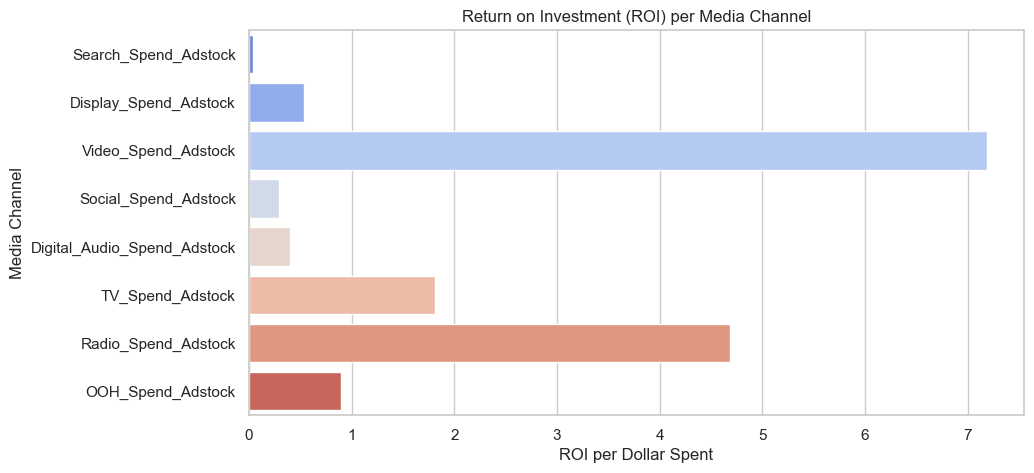

In [62]:
# Compute ROI: (Incremental Revenue / Spend)
roi_data = {}
for channel in [
    "Search_Spend_Adstock", "Display_Spend_Adstock", "Video_Spend_Adstock",
    "Social_Spend_Adstock", "Digital_Audio_Spend_Adstock", "TV_Spend_Adstock",
    "Radio_Spend_Adstock", "OOH_Spend_Adstock"
]:
    roi_data[channel] = (feature_importance[feature_importance["Feature"] == channel]["Importance"].values[0] * weekly_mmm["revenue"].sum()) / (weekly_mmm[channel].sum())

# Convert to DataFrame
roi_df = pd.DataFrame(list(roi_data.items()), columns=["Media Channel", "ROI"])

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x="ROI", y="Media Channel", data=roi_df, palette="coolwarm")
plt.xlabel("ROI per Dollar Spent")
plt.ylabel("Media Channel")
plt.title("Return on Investment (ROI) per Media Channel")
plt.show()

# Model As a Whole

In [35]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import HistGradientBoostingRegressor  # Alternative during GridSearch

# Define target variable
Y = "revenue"

# Define spend factors (adstocked spend per channel)
spend_factors = [
    "Search_Spend_Adstock",
    "Display_Spend_Adstock",
    "Video_Spend_Adstock",
    "Social_Spend_Adstock",
    "Digital_Audio_Spend_Adstock",
    "TV_Spend_Adstock",
    "Radio_Spend_Adstock",
    "OOH_Spend_Adstock"
]

# Define macroeconomic factors
macro_factors = [
    "Promo_Exists",
    "Consumer_Index",
    "Inflation_Rate",
    "Gross_Rating_Point"
]

# Feature Engineering: Normalize CTR using MinMaxScaler
scaler = MinMaxScaler()
weekly_mmm["CTR_Scaled"] = scaler.fit_transform(weekly_mmm[["CTR"]])

# Combine all features, including engineered CTR
X_columns = spend_factors + macro_factors + ["CTR_Scaled"]
X = weekly_mmm[X_columns]
y = weekly_mmm[Y]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---- GridSearchCV using HistGradientBoostingRegressor (avoiding XGBRegressor error) ----
param_grid = {
    'learning_rate': [0.01, 0.05, 0.07, 0.08, 0.09, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'max_iter': [50, 100, 200],
}

hist_gbr = HistGradientBoostingRegressor(random_state=42)

grid_search = GridSearchCV(hist_gbr, param_grid, cv=5, scoring='r2', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters from GridSearchCV
best_params = grid_search.best_params_
print("Best Parameters from GridSearchCV:", best_params)

# ---- Train Final XGBoost Model using Best Parameters ----
best_xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    n_estimators=best_params['max_iter'],  # Convert max_iter from HistGradientBoostingRegressor to n_estimators for XGBoost
    random_state=42
)

best_xgb_model.fit(X_train, y_train)

# Predictions with the optimized model
y_pred = best_xgb_model.predict(X_test)

# Model Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\nOptimized Model Performance:\nRMSE: {rmse:.2f}\nR-squared: {r2:.4f}")

# Feature importance analysis
feature_importance = pd.DataFrame({'Feature': X_columns, 'Importance': best_xgb_model.feature_importances_})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

print("\nFeature Importance:\n", feature_importance)

# Save the best model
best_xgb_model.save_model("optimized_mmm_xgboost_model.json")

Fitting 5 folds for each of 84 candidates, totalling 420 fits
Best Parameters from GridSearchCV: {'learning_rate': 0.1, 'max_depth': 3, 'max_iter': 200}

Optimized Model Performance:
RMSE: 433931.51
R-squared: 0.8305

Feature Importance:
                         Feature  Importance
2           Video_Spend_Adstock    0.441163
5              TV_Spend_Adstock    0.123870
6           Radio_Spend_Adstock    0.096983
11           Gross_Rating_Point    0.084671
12                   CTR_Scaled    0.082561
10               Inflation_Rate    0.068591
1         Display_Spend_Adstock    0.022587
7             OOH_Spend_Adstock    0.021943
9                Consumer_Index    0.019657
0          Search_Spend_Adstock    0.015992
4   Digital_Audio_Spend_Adstock    0.012839
3          Social_Spend_Adstock    0.009144
8                  Promo_Exists    0.000000
